In [8]:

import sys
from pathlib import Path

try:
    from models.rc_2r2c import RC2R2C, RC2R2CParams
except ModuleNotFoundError:
    ROOT = Path.cwd()
    SRC = ROOT / "src"
    if SRC.exists():
        sys.path.insert(0, str(SRC))
        from models.rc_2r2c import RC2R2C, RC2R2CParams
    else:
        raise

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

print("✅ Imports OK")


✅ Imports OK


In [9]:
# Parámetros del edificio (puedes ajustarlos)
params = RC2R2CParams(
    C_air=1.2e6,  # J/K
    C_mass=9.0e6, # J/K
    R_am=0.004,   # K/W
    R_ao=0.006,   # K/W
    dt=300.0      # 10 min
)
model = RC2R2C(params)

# Escenario
T_out = 283.15   # 10 °C (Kelvin)
T_sp  = 294.15   # 21 °C (Kelvin)
x0    = np.array([T_out + 2.0, T_out + 2.0])  # estado inicial "templado"

# Horizonte de predicción y duración de simulación
N = 12   # 4 h (24 * 10 min)
H = 36   # 6 h totales para ver el comportamiento

# Pesos del costo (ajusta el balance confort/energía)
Q = 1.0
R = 1e-2   # si u está en W, mantener R pequeño
rho_slack = 5e3  # penalización de violaciones de confort (soft-constraints)

# Límites (cajas)
u_min, u_max = 0.0, 5000.0                # W
T_in_min, T_in_max = 291.15, 297.15       # [18, 24] °C (en Kelvin)

print(f"dt={params.dt}s, N={N} pasos (~{N*params.dt/3600:.1f} h), H={H} pasos totales (~{H*params.dt/3600:.1f} h)")


dt=300.0s, N=12 pasos (~1.0 h), H=36 pasos totales (~3.0 h)


In [10]:
class LinearMPCQP:
    """
    MPC lineal (QP) con soft-constraints y escala de control:
      - u_var en kW dentro del QP (mejora la condición numérica).
      - Dinámica del modelo espera W -> se multiplica por 1000 al aplicar.
      - Soft-constraints en T_in con penalización rho_slack.
      - Ajustes de OSQP para evitar user_limit.
    """
    def __init__(self, model: RC2R2C, N: int, Q: float, R: float,
                 u_min: float, u_max: float, T_in_min: float, T_in_max: float,
                 rho_slack: float,
                 osqp_max_iter: int = 20000,
                 osqp_eps_abs: float = 1e-4,
                 osqp_eps_rel: float = 1e-4,
                 osqp_polish: bool = True,
                 use_ecos: bool = False):
        Ad, Bd, Ed = model.Ad, model.Bd, model.Ed
        self.Ad = np.array(Ad, dtype=float)
        self.Bd = np.array(Bd, dtype=float)
        self.Ed = np.array(Ed, dtype=float)

        self.N = int(N)
        self.Q = float(Q)
        # Importante: R ahora pondera u_var en kW (no en W)
        self.R = float(R)
        self.rho = float(rho_slack)

        # Escala de control
        self.u_scale = 1000.0  # kW -> W
        # Límites convertidos a kW
        self.u_min_kw = float(u_min) / self.u_scale
        self.u_max_kw = float(u_max) / self.u_scale

        self.T_in_min = float(T_in_min)
        self.T_in_max = float(T_in_max)

        # Solver settings
        self.use_ecos = bool(use_ecos)
        self.osqp_settings = dict(max_iter=osqp_max_iter,
                                  eps_abs=osqp_eps_abs,
                                  eps_rel=osqp_eps_rel,
                                  polish=osqp_polish,
                                  verbose=False,
                                  warm_start=True)

        nx = 2
        Np = self.N

        # Variables de decisión
        self.x = cp.Variable((nx, Np+1))
        self.u_kw = cp.Variable((1, Np))  # control en kW

        # Holguras (soft-constraints) para T_in
        self.s_lo = cp.Variable((1, Np+1), nonneg=True)
        self.s_hi = cp.Variable((1, Np+1), nonneg=True)

        # Parámetros
        self.x0   = cp.Parameter(nx)
        self.Tout = cp.Parameter()
        self.Tsp  = cp.Parameter()

        cost = 0
        cons = [self.x[:,0] == self.x0]

        # Bandas suaves en T_in (incluye k=0)
        for k in range(Np+1):
            cons += [ self.T_in_min - self.s_lo[:,k] <= self.x[0,k],
                      self.x[0,k] <= self.T_in_max + self.s_hi[:,k] ]

        # Dinámica + límites u (ahora en kW) + costo
        for k in range(Np):
            # Convertir u_kw (kW) a W en la dinámica
            cons += [ self.x[:,k+1] == self.Ad @ self.x[:,k]
                                   + self.Bd @ (self.u_kw[:,k] * self.u_scale)
                                   + self.Ed.flatten() * self.Tout ]
            cons += [ self.u_min_kw <= self.u_kw[:,k], self.u_kw[:,k] <= self.u_max_kw ]

            cost += self.Q * cp.square(self.x[0,k] - self.Tsp) + self.R * cp.sum_squares(self.u_kw[:,k])

        # Penalización de slacks (todas k)
        cost += self.rho * (cp.sum(self.s_lo) + cp.sum(self.s_hi))

        self.prob = cp.Problem(cp.Minimize(cost), cons)

    def control(self, x_now: np.ndarray, T_out: float, T_sp: float) -> float:
        self.x0.value = np.asarray(x_now, dtype=float).reshape(2,)
        self.Tout.value = float(T_out)
        self.Tsp.value  = float(T_sp)

        if self.use_ecos:
            _ = self.prob.solve(solver=cp.ECOS, verbose=False, max_iters=2000, abstol=1e-7, reltol=1e-7)
        else:
            _ = self.prob.solve(solver=cp.OSQP, **self.osqp_settings)

        if self.prob.status not in ("optimal", "optimal_inaccurate"):
            raise RuntimeError(f"MPC infeasible: {self.prob.status}")

        # Devolver u en W (convertimos de kW a W)
        return float(self.u_kw.value[0,0] * self.u_scale)


In [ ]:
mpc = LinearMPCQP(model, N=N, Q=Q, R=R,
                  u_min=u_min, u_max=u_max,
                  T_in_min=T_in_min, T_in_max=T_in_max,
                  rho_slack=rho_slack,
                  osqp_max_iter=20000, osqp_eps_abs=1e-4, osqp_eps_rel=1e-4, osqp_polish=True,
                  use_ecos=False)  # prueba True si quieres comparar

x = x0.copy()
log = {"T_in": [x[0]], "T_mass": [x[1]], "u": []}
for k in range(H):
    u_k = mpc.control(x_now=x, T_out=T_out, T_sp=T_sp)
    x = model.step(x, u_k, T_out)
    log["u"].append(u_k)
    log["T_in"].append(x[0])
    log["T_mass"].append(x[1])
print("✅ Simulación MPC terminada")



✅ Simulación MPC terminada


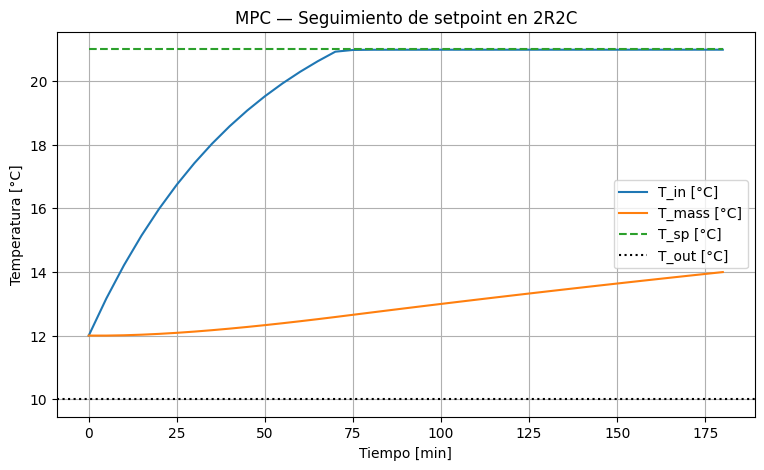

In [12]:
t_min = (np.arange(H+1) * params.dt) / 60.0

plt.figure(figsize=(9,5))
plt.plot(t_min, np.array(log["T_in"]) - 273.15, label="T_in [°C]")
plt.plot(t_min, np.array(log["T_mass"]) - 273.15, label="T_mass [°C]")
plt.plot(t_min, np.full(H+1, T_sp - 273.15), "--", label="T_sp [°C]")
plt.axhline(T_out - 273.15, color="k", linestyle=":", label="T_out [°C]")
plt.xlabel("Tiempo [min]")
plt.ylabel("Temperatura [°C]")
plt.title("MPC — Seguimiento de setpoint en 2R2C")
plt.grid(True)
plt.legend()
plt.show()


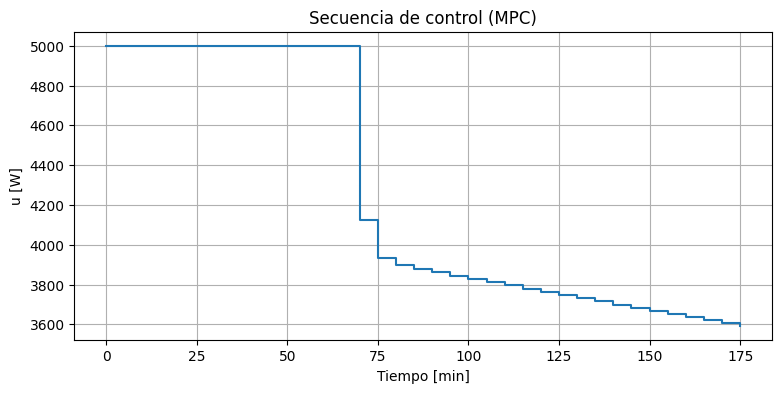

In [13]:
plt.figure(figsize=(9,4))
plt.step(np.arange(H) * (params.dt/60.0), np.array(log["u"]), where="post")
plt.xlabel("Tiempo [min]")
plt.ylabel("u [W]")
plt.title("Secuencia de control (MPC)")
plt.grid(True)
plt.show()


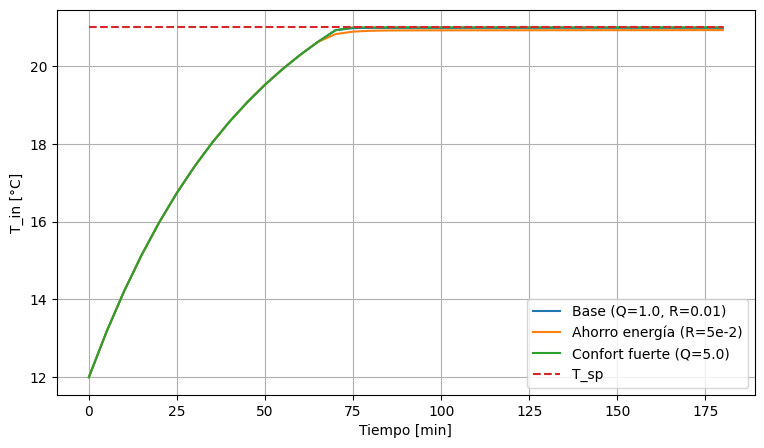

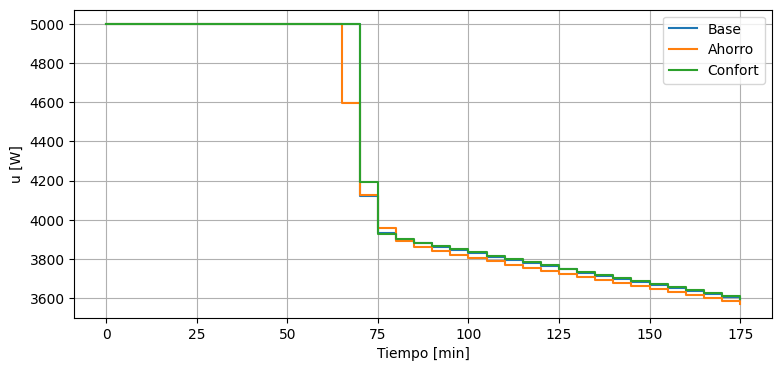

Costos -> Base: 307.8 | Ahorro: 334.1 | Confort: 1512.5


In [14]:
def run_mpc(Q=None, R=None, u_max=None, T_out_=None, T_sp_=None,
            N_override=None, rho_slack_=None,
            use_ecos=False, osqp_max_iter=20000, osqp_eps_abs=1e-4, osqp_eps_rel=1e-4, osqp_polish=True):
    """
    Ejecuta MPC para un set de hiperparámetros y devuelve logs.
    - Q, R penalizan (T_in - T_sp)^2 y u_kw^2 (recuerda: R en kW^2).
    - u_max en W (se reescala internamente a kW por la clase).
    - N_override permite cambiar el horizonte localmente.
    """
    Q_  = Q  if Q  is not None else globals()["Q"]
    R_  = R  if R  is not None else globals()["R"]
    umax_ = u_max if u_max is not None else globals()["u_max"]
    T_out__ = T_out_ if T_out_ is not None else globals()["T_out"]
    T_sp__  = T_sp_  if T_sp_  is not None else globals()["T_sp"]
    N_ = int(N_override) if N_override is not None else int(globals()["N"])
    rho_ = rho_slack_ if rho_slack_ is not None else globals()["rho_slack"]

    mpc_local = LinearMPCQP(
        model, N=N_, Q=Q_, R=R_,
        u_min=u_min, u_max=umax_,
        T_in_min=T_in_min, T_in_max=T_in_max,
        rho_slack=rho_,
        osqp_max_iter=osqp_max_iter,
        osqp_eps_abs=osqp_eps_abs,
        osqp_eps_rel=osqp_eps_rel,
        osqp_polish=osqp_polish,
        use_ecos=use_ecos
    )

    x = x0.copy()
    H_local = globals()["H"]
    log_local = {"T_in":[x[0]], "T_mass":[x[1]], "u":[]}
    for _ in range(H_local):
        u_k = mpc_local.control(x_now=x, T_out=T_out__, T_sp=T_sp__)
        x = model.step(x, u_k, T_out__)
        log_local["u"].append(u_k)
        log_local["T_in"].append(x[0])
        log_local["T_mass"].append(x[1])
    return log_local

def mpc_cost(T_in_seq, u_seq, T_sp_val, Q_val, R_val):
    """Costo sin contar slacks explícitos: sum Q*(T_in - T_sp)^2 + R*u_kw^2.
    Nota: nuestra clase penaliza u en kW. u_seq está en W -> convertir a kW.
    """
    T_in_seq = np.asarray(T_in_seq)
    u_kw = np.asarray(u_seq) / 1000.0
    return float(np.sum(Q_val*(T_in_seq[:-1]-T_sp_val)**2 + R_val*(u_kw**2)))

# Experimentos: sube/baja R (en kW^2) o Q
log_base = run_mpc()  # usa Q, R, rho_slack definidos en la celda de parámetros

# Más ahorro energía (R↑) y mismo Q:
log_energy_saver = run_mpc(R=5e-2)     # si tu R base es 1e-2, esto ahorra más
# Más confort (Q↑) y mismo R:
log_comfort_hunter = run_mpc(Q=5.0)

# Graficar
t_min = (np.arange(H+1) * params.dt) / 60.0
plt.figure(figsize=(9,5))
plt.plot(t_min, np.array(log_base["T_in"])-273.15, label=f"Base (Q={Q}, R={R})")
plt.plot(t_min, np.array(log_energy_saver["T_in"])-273.15, label="Ahorro energía (R=5e-2)")
plt.plot(t_min, np.array(log_comfort_hunter["T_in"])-273.15, label="Confort fuerte (Q=5.0)")
plt.plot(t_min, np.full(H+1, T_sp-273.15), "--", label="T_sp")
plt.xlabel("Tiempo [min]")
plt.ylabel("T_in [°C]")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(9,4))
plt.step(np.arange(H)*(params.dt/60.0), np.array(log_base["u"]), where="post", label="Base")
plt.step(np.arange(H)*(params.dt/60.0), np.array(log_energy_saver["u"]), where="post", label="Ahorro")
plt.step(np.arange(H)*(params.dt/60.0), np.array(log_comfort_hunter["u"]), where="post", label="Confort")
plt.xlabel("Tiempo [min]")
plt.ylabel("u [W]")
plt.grid(True)
plt.legend()
plt.show()

# Costos comparativos (recuerda: R penaliza kW^2)
cost_base = mpc_cost(log_base["T_in"], log_base["u"], T_sp, Q, R)
cost_energy = mpc_cost(log_energy_saver["T_in"], log_energy_saver["u"], T_sp, Q, 5e-2)
cost_comfort = mpc_cost(log_comfort_hunter["T_in"], log_comfort_hunter["u"], T_sp, 5.0, R)
print(f"Costos -> Base: {cost_base:.1f} | Ahorro: {cost_energy:.1f} | Confort: {cost_comfort:.1f}")
